# **Kaggle Plant Pathology Classification with Xception Model**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import shutil
import cv2
import numpy as np

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, MaxPooling2D, Flatten, BatchNormalization, GaussianNoise, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
import pandas as pd,numpy as np,pylab as pl

%matplotlib inline

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
#### Trainings DATAFRAME #########

from IPython.display import Image
data_dir = '/content/drive/My Drive/Colab Notebooks/Plant Pathology/'
training_images = '/content/drive/My Drive/Colab Notebooks/Plant Pathology/images/'

#display(Image(training_images + '14.png'))
#display(Image(training_images + 'Test_0.jpg'))
traindf=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Plant Pathology/train.csv', dtype=str)
traindf['healthy'] = traindf['healthy'].astype(str)
traindf['multiple_diseases'] = traindf['multiple_diseases'].astype(str)
traindf['rust'] = traindf['rust'].astype(str)
traindf['scab'] = traindf['scab'].astype(str)
def append_ext(fn):
    return fn+".jpg"
traindf["image_id"]=traindf["image_id"].apply(append_ext)

## **Data preprocessing**

In [4]:
#### DATA PREPROZESSING ####

image_size = 224 # All images will be resized to 224x224
batch_size = 32
import random


def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

# Prepare data-augmenting data generator

train_datagen_I = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
    preprocessing_function=add_noise,
    validation_split=0.25
)

validation_datagen_I=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
train_generator_I = train_datagen_I.flow_from_dataframe(dataframe=traindf, directory=training_images,
                                             x_col='image_id',
                                             y_col=['healthy','multiple_diseases','rust','scab'],
                                             target_size=(image_size, image_size),
                                             batch_size=batch_size,
                                             class_mode='raw',
                                             subset='training',
                                             shuffle=True,
                                             seed=7)
validation_generator_I = validation_datagen_I.flow_from_dataframe(dataframe=traindf, directory=training_images,
                                             x_col='image_id',
                                             y_col=['healthy','multiple_diseases','rust','scab'],
                                             target_size=(image_size, image_size),
                                             class_mode='raw',
                                             batch_size=batch_size,
                                             shuffle=True,
                                             subset='validation',
                                             seed=7)

Found 1366 validated image filenames.
Found 455 validated image filenames.


### **Show images (optional)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


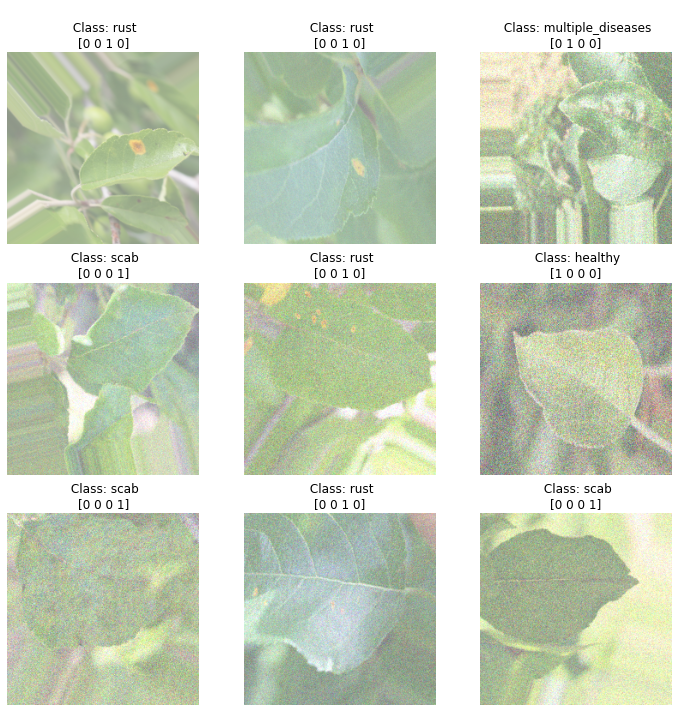

In [5]:
####   SHOW AUGMENTED IMAGES   ####

import typing
def plot_images_with_labels(
    images: typing.List[int], labels: np.ndarray, class_names: typing.List[str]) -> None:
    if len(images) != 9:
        images = images[:9]
        labels = labels[:9]
    labels = labels.astype(int)

    plt.figure(figsize=(12, 12))
    index = 0
    for image, label in zip(images, labels):
        index += 1
        plt.subplot(3, 3, index)
        plt.imshow(image)
        plt.title("\n Class: " + format(class_names[label.argmax()]) + "\n" + format(label))
        plt.axis("off")

# plot some augmented images
X_augmented, y_augmented = next(train_generator_I)
plot_images_with_labels((X_augmented + 1) / 2, y_augmented, ['healthy','multiple_diseases','rust','scab'])
# X_augmented, y_augmented = next(validation_generator_I)
# plot_images_with_labels((X_augmented + 1) / 2, y_augmented, ['healthy','multiple_diseases','rust','scab'])

## **Transfer learning model with Xception pre-train model and a new Fully-Connected-Classifier**
*   ### **fine-tuning**
*   ### **data augmentation with random nois**
*   ### **Optimizer RMSprop(lr=0.00008)**
*   ### **class weight (because multiple_deseases are underrepresented)**
*   ### **batch normalizing**
*   ### **dropout**

In [6]:
####    BILD THE MODEL WITH XCEPTION AND RMSprop OPTIMIZER ####

from tensorflow.keras.applications.xception import Xception

n_classes = 4
# build a transfer learning model with Xception and a new Fully-Connected-Classifier
base_model = Xception(
    weights='imagenet',
    include_top=False
)

i=0

while i < len(base_model.layers):
    base_model.layers[i].trainable = True
    i += 2

model = GlobalAveragePooling2D()(base_model.output)
model = BatchNormalization()(model)
model = Dropout(0.5)(model)

# include own Fully-Connected-Classifier
output_layer = Dense(n_classes, activation='softmax')(model)

# create Model
model = Model(base_model.input, output_layer)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Fit the Model with class_weight

In [7]:
from sklearn.utils import class_weight
# Saving the model
# Directory where the checkpoints will be saved
checkpoint_dir = data_dir + 'training_checkpoints'
#os.makedirs(checkpoint_dir, exist_ok = True)
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_training_xception_class_weight")


checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=0.00008),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
steps_per_epoch = train_generator_I.n // batch_size
validation_steps = validation_generator_I.n // batch_size

class_weight = {0: 1.,
                1: 2.,
                2: 1.,
                3: 1.}

historyI = model.fit_generator(train_generator_I,
                              steps_per_epoch = steps_per_epoch,
                              epochs=40,
                              validation_data=validation_generator_I,
                              class_weight=class_weight,
                              callbacks=[checkpoint_callback])

Epoch 1/40
42/42 [==============================] - 1028s 24s/step - loss: 1.8405 - acc: 0.4063 - val_loss: 1.2507 - val_acc: 0.4901
Epoch 2/40
42/42 [==============================] - 132s 3s/step - loss: 1.2247 - acc: 0.6214 - val_loss: 0.8348 - val_acc: 0.7165
Epoch 3/40
42/42 [==============================] - 137s 3s/step - loss: 1.0490 - acc: 0.6972 - val_loss: 0.6784 - val_acc: 0.8022
Epoch 4/40
42/42 [==============================] - 138s 3s/step - loss: 0.8736 - acc: 0.7549 - val_loss: 0.6426 - val_acc: 0.8440
Epoch 5/40
42/42 [==============================] - 139s 3s/step - loss: 0.7036 - acc: 0.7751 - val_loss: 0.7183 - val_acc: 0.8549
Epoch 6/40
42/42 [==============================] - 140s 3s/step - loss: 0.6066 - acc: 0.8231 - val_loss: 0.7138 - val_acc: 0.8462
Epoch 7/40
42/42 [==============================] - 142s 3s/step - loss: 0.5890 - acc: 0.8231 - val_loss: 0.6673 - val_acc: 0.8571
Epoch 8/40
42/42 [==============================] - 143s 3s/step - loss: 0.4270 -

In [11]:
#### DATA PREDICTION ####
data_dir = '/content/drive/My Drive/Colab Notebooks/Plant Pathology/'
test_images = '/content/drive/My Drive/Colab Notebooks/Plant Pathology/images/'

testdf=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Plant Pathology/test.csv', dtype=str)
def append_ext(fn):
    return fn+".jpg"
testdf["image_id"]=testdf["image_id"].apply(append_ext)
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

image_size = 224 # All images will be resized to 224x224
batch_size = 1

test_generator = test_datagen.flow_from_dataframe(dataframe=testdf, directory=test_images,
                                             x_col='image_id',
                                             target_size=(image_size, image_size),
                                             batch_size=batch_size,
                                             class_mode=None,
                                             shuffle=False)


filenames = test_generator.filenames
nb_samples = len(filenames)

steps = test_generator.n // batch_size

predict = model.predict_generator(test_generator, 200)

np.savetxt(data_dir + "cur_predict_test.csv", predict, fmt="%10.3f")
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print("Accuracy = ", predict)


Found 1821 validated image filenames.
Accuracy =  [[0.000 0.000 1.000 0.000]
 [0.000 0.001 0.999 0.000]
 [0.001 0.001 0.000 0.998]
 [1.000 0.000 0.000 0.000]
 [0.000 0.001 0.999 0.000]
 [0.993 0.000 0.007 0.000]
 [1.000 0.000 0.000 0.000]
 [0.000 0.001 0.000 0.999]
 [0.000 0.097 0.000 0.903]
 [0.000 0.001 0.999 0.000]
 [0.000 0.000 1.000 0.000]
 [0.988 0.000 0.012 0.000]
 [0.004 0.008 0.000 0.988]
 [0.999 0.000 0.001 0.000]
 [0.000 0.002 0.998 0.000]
 [0.000 0.000 1.000 0.000]
 [1.000 0.000 0.000 0.000]
 [0.000 0.010 0.000 0.990]
 [0.630 0.001 0.164 0.205]
 [0.000 0.000 1.000 0.000]
 [0.000 0.000 0.000 1.000]
 [1.000 0.000 0.000 0.000]
 [0.004 0.021 0.975 0.000]
 [0.000 0.000 0.000 1.000]
 [1.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 1.000]
 [0.001 0.000 0.000 0.999]
 [0.000 0.000 1.000 0.000]
 [1.000 0.000 0.000 0.000]
 [0.512 0.200 0.160 0.128]
 [1.000 0.000 0.000 0.000]
 [0.000 0.013 0.987 0.000]
 [0.000 0.000 0.000 1.000]
 [0.000 0.000 0.000 1.000]
 [0.002 0.000 0.000 0.998]
 [0.0

In [0]:
def plot_learning_curve(
    title: str, x: int, y: int, y_test: int, ylim: float = 0.6
) -> None:
    plt.figure()
    plt.title(title)
    axes = plt.gca()
    axes.set_ylim([ylim, 1])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    train_sizes = x
    train_scores = y
    test_scores = y_test

    plt.grid()

    plt.plot(
        train_sizes,
        train_scores,
        "o-",
        color=(177 / 255, 6 / 255, 58 / 255),
        label="Training accuracy",
    )
    plt.plot(
        train_sizes,
        test_scores,
        "o-",
        color=(246 / 255, 168 / 255, 0),
        label="Validation accuracy",
    )

    plt.legend(loc="best")


def plot_history(title: str, history: "History", ylim: float = 0.6) -> None:
    y = history.history["acc"]
    y_test = history.history["val_acc"]
    plot_learning_curve(title, np.arange(1, 1 + len(y)), y, y_test, ylim)



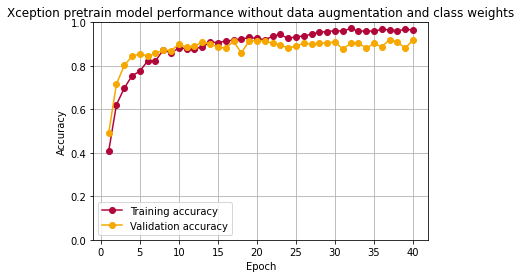

In [14]:
plot_history('Xception pretrain model performance without data augmentation and class weights', historyI, 0)
#plot_history('Pretrain model performance with fine-tuning with data augmentation', historyII, 0)
#plot_history('Pretrain model performance with fine-tuning without data augmentation', historyIII, 0)

## Summary

### The following techniques were used to improve regularization:
*   ### fine-tuning of half of the layers of the Xception
*   ### data augmentation (amongst others with random nois)
*   ### Optimizer RMSprop at a very small learning rate(lr=0.00008)
*   ### class weight (because multiple_deseases are underrepresented)
*   ### batch normalizing and dropout between the base_model and own Fully-Connected-Classifier


### All of these techniques have improved regularization very well and avoided overfitting. Unfortunately, this all did not improve the validation accuracy :(
